In [1]:
library(MASS) # required for PCAtest
library(Seurat)
library(dplyr)
library(tidyverse)
library(ICtest) # does bootstrapped analysis of significance of PCA for ICA https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html
library(stats)
# this works in Rstudio but on the notebooks it spits out a 
#library(RGCCA) # regularized CCA vignette here:
# can give significances of individual parts of compenents (I think)
library(PCAtools)

#if (!requireNamespace('BiocManager', quietly = TRUE))
#  install.packages('BiocManager')
#BiocManager::install('PCAtools')
library(loadings)
# statistical singificnace from boots trap for PCA https://peerj.com/articles/12967.pdf
library(PCAtest) # devtools::install_github("arleyc/PCAtest")
# avoids axis inversion "In addition, the problem of ‘axis reflection’ (i.e., the arbitrary permutation of
#signs among loadings and PC scores), which is well known in the literature (Jackson,
#1995; Mehlman, Shepherd & Kelt, 1995; Peres-Neto, Jackson & Somers, 2003, 2005), is
#effectively avoided with these two statistics as originally implemented by Vieira (2012) and
#in the R package introduced here"
library(RColorBrewer)
# another potential contender: https://rdrr.io/github/ucsf-ferguson-lab/syndRomics/man/boot_pca_sample.prcomp.html
# also claims to avoid axis inversion

# this can compute significant loadings on PCA
# library(loadings)
# this functions pca_loading() take prcomp as input
# https://cran.r-project.org/web/packages/loadings/loadings.pdf

# Yamamoto, H., Fujimori, T., Sato, H., Ishikawa, G., Kami, K., & Ohashi, Y. (2014). 
# Statistical hypothesis testing of factor loading in principal component analysis and its application 
# to metabolite set enrichment analysis. BMC bioinformatics, 15, 1-9.

Attaching SeuratObject

Attaching sp


Attaching package: 'dplyr'


The following object is masked from 'package:MASS':

    select


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


-- Attaching packages --------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.4.0     v purrr   0.3.4
v tibble  3.1.8     v stringr 1.4.1
v tidyr   1.2.1     v forcats 0.5.2
v readr   2.1.3     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
x dplyr::select() masks MASS::select()

Loading required package: JADE

Loading required package: ICS

Loading required package: mvtnorm

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Loading required package: ggrepel


Attaching package: 'PCAtools'


The following objects are masked from 

ERROR: Error in library(PCAtest): there is no package called 'PCAtest'


ERROR: Error in library(loadings): there is no package called 'loadings'


In [4]:
# for bootstrapping significance from PCA
# ICtest library
# https://cran.r-project.org/web/packages/ICtest/ICtest.pdf
# https://cran.r-project.org/web/packages/ICtest/index.html
# https://cran.r-project.org/web/packages/ICtest/vignettes/PCA.html
#install.packages('ICtest')

In [235]:
# function for cross validated CCA
#https://rdrr.io/github/giac01/ccatools/man/cca_cv_boot.html
#install.packages('ccatools')

ERROR: Error in library(Rfast): there is no package called 'Rfast'


In [5]:
# set paths
# from this pub: https://www.nature.com/articles/s41586-022-04915-7#Sec5
# cell assingments were done with this: 
bugeon.path <- '/space/scratch/Bugeon2022_merfish_ca2plus/'


# Hrvatin, S., Hochbaum, D. R., Nagy, M. A., Cicconet, M., Robertson, K., Cheadle, L., ... & Greenberg, M. E. (2018). 
# Single-cell analysis of experience-dependent transcriptomic states in the mouse visual cortex. Nature neuroscience, 21(1), 120-129.
#From here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5742025/
hrvatin.path <- '/home/acampbell/test_datasets/Hrvatin2018/'

bahl2022.path <- '/home/acampbell/PavLabEngrams/IEG_gradients/neurestimator_iegs_list.csv'

tasic.path <- '/space/scratch/Tasic2018_GSE115746/'

neurestimator.iegslist.path <- paste(getwd(),'/','neuroestimator_iegs_list.csv',sep='')
neurestimator.iegslist.path

[1] "/home/acampbell/PavLabEngrams/IEG_gradients/neuroestimator_iegs_list.csv"

In [ ]:
hg_to_mm <- 'PavLabEngrams/EngramCellClassifier/hg_mm_1to1_ortho_genes_DIOPT-v8.tsv'

In [2]:
getwd()

[1] "/home/acampbell/PavLabEngrams/IEG_gradients"

In [206]:
# functions

pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  # Almost as Seurat::NormalizeData but we use log2 rather than natural log
  # from here https://satijalab.org/seurat/reference/normalizedata
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x)/counts # Feature counts for each cell are divided by the total counts for that cell...
  x <- x*scale_factor # and multiplied by the scale.factor. 
  # the we log2 plus 1 rather than natural log plus 1 seurat uses
  return(log2(x+1))
}

pavlab.normalize <- function(df, UMI = NULL, median.scale=FALSE, scaleby = 10000){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if(median.scale){ scaleby = median(UMI)}
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
    #
    df[] <- Map(pseudocount_log2p1_transform, df, scale_factor = scaleby, UMI.provided = UMI)
    
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}

# for finding nth hihgest value, we use it for fincing geens of highest varience
maxN <- function(x, N=2){
    len <- length(x)
    if(N>len){
        warning('N greater than length(x).  Setting N=length(x)')
        N <- length(x)
    }
    sort(x,partial=len-N+1)[len-N+1]
}

# to write pheatmap images to file as a .png
save_pheatmap <- function(x, filename, width=480, height=960) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename,width = width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

### Gene Lists

I put together several lists of genes.

Bugeon et al., (2022) coppaFISH probes, chosen on basis of being best able to disntinguish cell types in V1.  I also wrote out the order they came in in tPC1 they report in thier publication.  Coppied from figure 5.

From Bahl et al., (2022), not a published paper just a preprint.  Use their IEGs, the 41 thy had before filtering to the most correlated together.  These are just the genes that shoed differntial expression in response to some stimulation paradigm with a fold change of 0.5 across thre three studies they chose.  I did not include their last criteria for gene being correlated to one another because I wanted genes that may be more likely to exhibit gradient effects.

Ensemble protien coding mouse genes with stable transcript IDs and unique mapping.

In [60]:
#gene order of bugeon tPC1
tPC1.bugeon2022 <- c("Pvalb","Slc6a1","Gad1","Lhx6","Serpini1","Tac1","Npy","Cox6a2",
                    "Gabrd","Rgs4","Cort","Prkca","Crhbp","Sst","Satb1","Calb1","Ntng1",
                    "Col25a1","Rasgrf2","Nrn1","Rab3c", "Bcl11b","Cdh13","Neurod6","Enpp2",
                    "Hapln1","Wfs1","Pthlh","Lamp5","Kcnk2","Thsd7a","Aldoc","Grin3a","Plcxd2",
                    "Slc17a8","Plp1","Th","Chodl","Nr4a2","Nos1","Cpne5","Chrm2","Gda",
                    "Nov","Npy2r","Sema3c","Ndnf","Sncg","Kctd12","Pcp4","Calb2","Trp53i11",
                    "Cck","Rgs10","Pde1a","Cryab","Crh","Cadps2","Pnoc","Synpr","Id2","Rgs12",
                    "Snca","Penk","Kit","Cplx2","Reln","Tac2","Htr3a","Vip","Cnr1","Cxcl14")

In [6]:
# named meta for being required to exhibit a 0.5 foldchnage in 2 out of 3 studies from Bahl et al., 2022 in biorvx
# neuroestimator studies are PMID: 31501571, PMID: 29681534, PMID: 24855953
bahl.meta.iegs.df <- read.csv(bahl2022.path)
meta.iegs <- bahl.meta.iegs.df$stimulus_responsive_gene
meta.iegs

[1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Grasp"    "Herpud1"  "Ier2"     "Junb"     "Klf4"    
[25] "Mbnl2"    "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"   
[31] "Peg10"    "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"    
[37] "Rgs2"     "Sertad1"  "Sik1"     "Stard4"   "Tiparp"

In [7]:
# gene names of protien coding genes in mice
prot.coding.genes.ensmlble.df <- read.csv('/home/acampbell/PavLabEngrams/IEG_gradients/unique_stablestranscriptIDs_m39_gene_names.txt')
mouse.prot.coding.genes <- unique(prot.coding.genes.ensmlble.df$Gene.name) # we don't need to map ensemble id's to gene names
print(paste("There are this many unique protien coding gene names in our list:", as.character(length((mouse.prot.coding.genes)), sep='')))
head(prot.coding.genes.ensmlble.df)

[1] "There are this many unique protien coding gene names in our list: 21751"


,Gene.stable.ID,Gene.stable.ID.version,Transcript.stable.ID,Transcript.stable.ID.version,Gene.name
,<chr>,<chr>,<chr>,<chr>,<chr>
1,ENSMUSG00000064341,ENSMUSG00000064341.1,ENSMUST00000082392,ENSMUST00000082392.1,mt-Nd1
2,ENSMUSG00000064345,ENSMUSG00000064345.1,ENSMUST00000082396,ENSMUST00000082396.1,mt-Nd2
3,ENSMUSG00000064351,ENSMUSG00000064351.1,ENSMUST00000082402,ENSMUST00000082402.1,mt-Co1
4,ENSMUSG00000064354,ENSMUSG00000064354.1,ENSMUST00000082405,ENSMUST00000082405.1,mt-Co2
5,ENSMUSG00000064356,ENSMUSG00000064356.1,ENSMUST00000082407,ENSMUST00000082407.1,mt-Atp8
6,ENSMUSG00000064357,ENSMUSG00000064357.1,ENSMUST00000082408,ENSMUST00000082408.1,mt-Atp6


## Datasets we will use

Hrvatin et al., (2018) Dark house mice then exposed to light at 0h (no exposure), 1hr, 4hrs 5hrs (double chekc these time points).

Tasic et al., (2018) COntains scRNA-seq from allen brain institute of multiple cortical regions including mouse V1.   Comes with detailed metadata that Bugeon based their classification hierachy on.



In [15]:
hrvatin2018.meta <- read.csv(paste(hrvatin.path,'GSE102827_cell_type_assignments.csv.gz', sep = ''))
head(hrvatin2018.meta)

,X,stim,sample,maintype,celltype,subtype
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,x2_35_0_bc0013,0h,B1_1_0h,Excitatory,ExcL4,ExcL4_3
2,x2_35_0_bc0014,0h,B1_1_0h,Excitatory,ExcL5_3,NA
3,x2_35_0_bc0016,0h,B1_1_0h,Excitatory,ExcL5_2,NA
4,x2_35_0_bc0017,0h,B1_1_0h,Excitatory,ExcL6,NA
5,x2_35_0_bc0018,0h,B1_1_0h,Excitatory,ExcL5_3,NA
6,x2_35_0_bc0019,0h,B1_1_0h,Excitatory,ExcL23,ExcL23_1


In [16]:
table(hrvatin2018.meta$celltype)


     Astro     Endo_1     Endo_2     ExcL23      ExcL4    ExcL5_1    ExcL5_2 
      7039       3327        123       2963       3198       1976        410 
   ExcL5_3      ExcL6        Hip    Int_Cck    Int_Npy     Int_Pv  Int_Sst_1 
      1407       3276        137         91        137        227        174 
 Int_Sst_2    Int_Vip Macrophage    Micro_1    Micro_2      OPC_1      OPC_2 
       181        126        537        549       9609       1725        101 
    Olig_1     Olig_2     Olig_3     Olig_4     Olig_5     Olig_6     Olig_7 
       610        964        846       4047        747        786        630 
  Pericyte        RSP       SM_1       SM_2        Sub 
       782        420        323        298        500 

In [ ]:
# cell types in figure 1f Int_Cck, Int_Npy, Int_Pv, Int_Sst_1, Int_Sst_2, Int_Vip

In [ ]:
hrvatin2018.counts <- read.csv(paste(hrvatin.path, 'GSE102827_merged_all_raw.csv.gz',sep=''))

In [ ]:
dim(hrvatin2018.counts)

In [ ]:
rownames(hrvatin2018.counts) <- hrvatin2018.counts$X

In [ ]:
# sum(is.na(hrvatin2018.counts)) #this will show no na's
hrvatin2018.counts <- hrvatin2018.counts[,2:dim(hrvatin2018.counts)[2]]

In [ ]:
head(hrvatin2018.counts)

In [ ]:
hrvatin2018.meta$umi <- colSums(hrvatin2018.counts)
print(hrvatin2018.meta$umi[1:10])
hrvatin2018.umi.medianforscalefactor <- median(hrvatin2018.meta$umi)
print(hrvatin2018.umi.medianforscalefactor)

In [ ]:
hrvatin.inhibitory.idx <- grep('Int', hrvatin2018.meta$celltype)
length(hrvatin.inhibitory.idx)

In [27]:
bugeon2022.genes <- as.list(read.table(paste(bugeon.path,'genes.names.txt',sep ='')))
bugeon2022.genes <- bugeon2022.genes$V1
print(length(bugeon2022.genes))
bugeon2022.genes
# spearmen rank correlation between Bugeon genes and PC1 ranking of them from Hrvatin or Taisic

[1] 72


[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [ ]:
bugeon2022.genes

In [ ]:
tPC1.bugeon2022 %in% bugeon2022.genes$V1

In [ ]:
tPC1.bugeon2022[!(tPC1.bugeon2022 %in% bugeon2022.genes)]

### Hrvatin

Note this data is from dark housed mice exposed ot light for the first time, it's hardly a natural setting.

In [42]:
hrvatin.counts.inhibitory <- hrvatin2018.counts[,hrvatin.inhibitory.idx]
hrvatin.counts.inhibitory.normed <- pavlab.normalize(hrvatin.counts.inhibitory, 
                                                     UMI=hrvatin2018.meta$umi[hrvatin.inhibitory.idx], 
                                                     scaleby = hrvatin2018.umi.medianforscalefactor)

In [58]:
hrvatin.counts.inhibitory.normed <- as.data.frame(scale(t(hrvatin.counts.inhibitory.normed)))
rownames(hrvatin.counts.inhibitory.normed) <- colnames(hrvatin.counts.inhibitory)
colnames(hrvatin.counts.inhibitory.normed) <- rownames(hrvatin.counts.inhibitory)

In [58]:
#GSE115746_accession_table.csv.gz  GSE115746_cells_exon_counts.csv.gz  GSE115746_complete_metadata_28706-cells.csv.gz  GSE115746_controls_exon_counts.csv.gz

In [59]:
hrvatin.inhib.pca <- pca(hrvatin.counts.inhibitory.normed)

Looks like the activity state of the cells is dominating the data.  There is one PC and no others according to this.

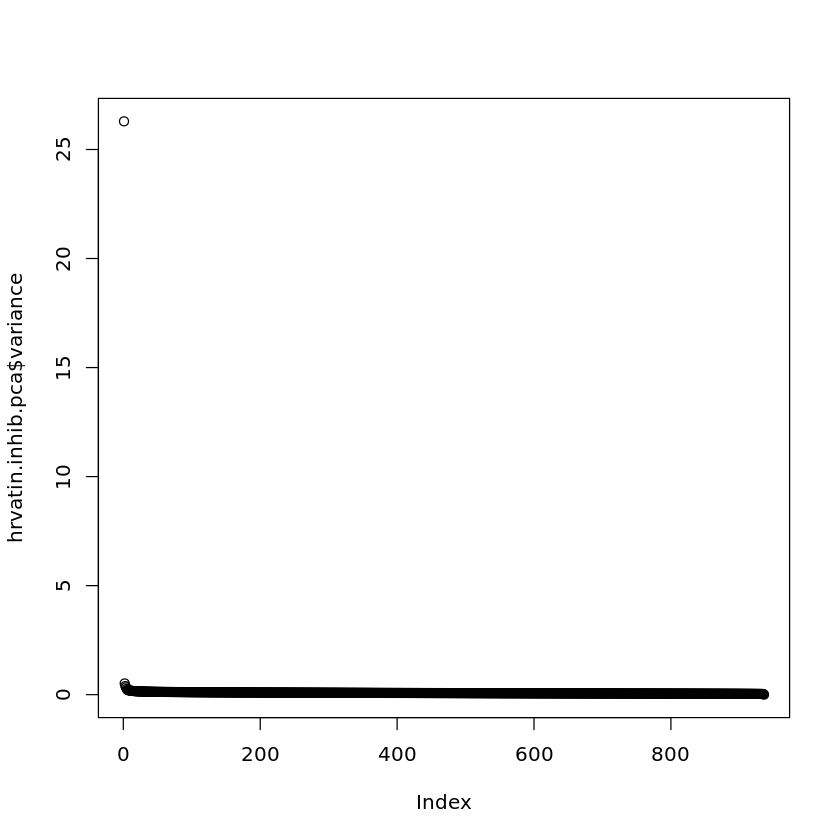

In [88]:
plot(hrvatin.inhib.pca$variance)

In [93]:
tPC1_fromrnaseq.hrvatingenes <- data.frame(gene = colnames(hrvatin.counts.inhibitory.normed), tPC1=hrvatin.inhib.pca$rotated$PC1) %>%
    arrange(tPC1)
print(dim(tPC1_fromrnaseq.hrvatingenes ))
head(tPC1_fromrnaseq.hrvatingenes)

[1] 25187     2


,gene,tPC1
,<chr>,<dbl>
1,Ndrg4,-29.44504
2,Snap25,-29.10790
3,Atp1b1,-28.55170
4,Calm2,-27.94055
5,Ppia,-27.68914
6,Tspyl4,-27.61248


In [112]:
tPC1_fromrnaseq.bugeongenes <- tPC1_fromrnaseq.hrvatingenes[tPC1_fromrnaseq.hrvatingenes$gene %in% bugeon2022.genes,]
tPC1_fromrnaseq.bugeongenes 

,gene,tPC1
,<chr>,<dbl>
34,Slc6a1,-24.61856
48,Serpini1,-24.16568
275,Satb1,-20.71906
543,Rasgrf2,-19.30147
559,Pvalb,-19.24926
651,Gad1,-18.92433
1204,Sst,-17.54816
1275,Cdh13,-17.43823
1328,Rab3c,-17.34893


In [113]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromrnaseq.bugeongenes$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromrnaseq.bugeongenes$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

In [120]:
tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin <- rank.tPC1.from_rnaseq
tPC1_fromrnaseq.bugeongenes$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromrnaseq.bugeongenes$gene <- as.factor(tPC1_fromrnaseq.bugeongenes$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

In [121]:
head(tPC1_fromrnaseq.bugeongenes)

,gene,tPC1,rank_in_hrvatin,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
34,Slc6a1,-24.61856,1,5
48,Serpini1,-24.16568,2,1
275,Satb1,-20.71906,3,6
543,Rasgrf2,-19.30147,4,15
559,Pvalb,-19.24926,5,2
651,Gad1,-18.92433,6,19


In [123]:
cor.test( tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin,  tPC1_fromrnaseq.bugeongenes$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin and tPC1_fromrnaseq.bugeongenes$rank_in_bugeon
S = 29142, p-value = 7.09e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5113682 


So we have a good correlation when we use all the genes in Hrvatin, rember that this is a highly abnormal dataset,
these mice have been darkhoused for 2 months.  Both resticting it to the Bugeon genes only and computing PCs as well as just the original mapping presserves the rank of the genes in the PC, though admittedly they all have the same sign in the full gene list (i.e. are all positively or negatively loaded).

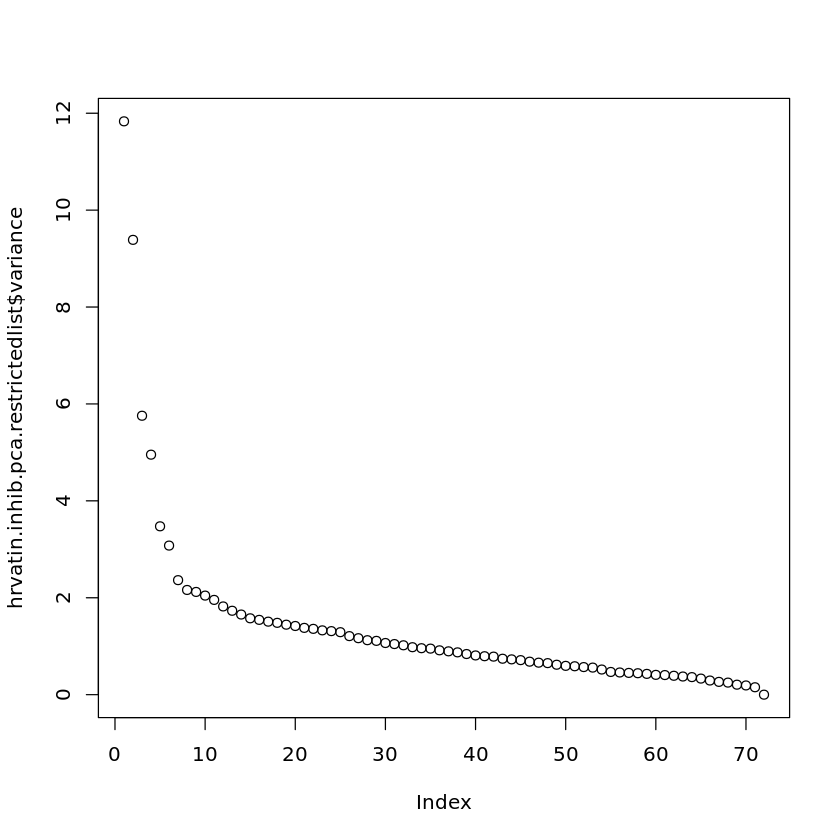

In [124]:
# and if we calculate it with just the bugeon genes for the pca?
hrvatin.inhib.pca.restrictedlist <- pca(hrvatin.counts.inhibitory.normed[,bugeon2022.genes])
plot(hrvatin.inhib.pca.restrictedlist$variance)

This looks a little healthier honestly.

In [126]:
colnames(hrvatin.counts.inhibitory.normed[,bugeon2022.genes])

[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [129]:
tPC1_fromrnaseq.hrvatingenes <- data.frame(gene = colnames(hrvatin.counts.inhibitory.normed[,bugeon2022.genes]),
                                           tPC1 = hrvatin.inhib.pca.restrictedlist$rotated$PC1) %>% arrange(tPC1)
    
print(dim(tPC1_fromrnaseq.hrvatingenes ))
tPC1_fromrnaseq.hrvatingenes

[1] 72  2


gene,tPC1
<chr>,<dbl>
Id2,-18.870612
Kit,-18.070806
Pnoc,-17.157784
Rab3c,-15.127785
Lamp5,-14.940581
Cryab,-13.533719
Gad1,-13.213847
Cck,-12.943226
Hapln1,-12.783874


In [130]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromrnaseq.bugeongenes$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromrnaseq.bugeongenes$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

In [131]:
tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin <- rank.tPC1.from_rnaseq
tPC1_fromrnaseq.bugeongenes$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromrnaseq.bugeongenes$gene <- as.factor(tPC1_fromrnaseq.bugeongenes$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

[1] "34"    "48"    "275"   "543"   "559"   "651"   "1204"  "1275"  "1328" 
[10] "1479"  "1504"  "1544"  "1573"  "1693"  "1931"  "1947"  "1954"  "2797" 
[19] "3063"  "3450"  "3487"  "3614"  "3646"  "3818"  "3843"  "3849"  "4143" 
[28] "4182"  "4201"  "4309"  "4424"  "4600"  "4644"  "4964"  "4991"  "5067" 
[37] "5096"  "5209"  "5493"  "5618"  "5755"  "6250"  "6303"  "6491"  "7140" 
[46] "7277"  "7360"  "7409"  "8074"  "8137"  "8172"  "8746"  "8793"  "8865" 
[55] "9035"  "9097"  "9155"  "9548"  "10250" "10320" "10335" "10385" "10560"
[64] "10671" "10795" "11144" "11209" "11380" "11518" "12184" "12308" "12597"

In [132]:
head(tPC1_fromrnaseq.bugeongenes)

,gene,tPC1,rank_in_hrvatin,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
34,Slc6a1,-24.61856,1,5
48,Serpini1,-24.16568,2,1
275,Satb1,-20.71906,3,6
543,Rasgrf2,-19.30147,4,15
559,Pvalb,-19.24926,5,2
651,Gad1,-18.92433,6,19


In [133]:
cor.test( tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin,  tPC1_fromrnaseq.bugeongenes$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromrnaseq.bugeongenes$rank_in_hrvatin and tPC1_fromrnaseq.bugeongenes$rank_in_bugeon
S = 29142, p-value = 7.09e-06
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5113682 


So the rank correlation is 0.5 between both datasets for the ordering on  PC1 of the gtranscriptomic data in Hrvatin and Bugeon.
with decent significance.  Enough to pass a bonferroni threshold for a number of tests.  You can also note Just by lookuing at the major cell type markers in the PCs that they oppose one another, espescially in the restricted list PC.  This is just from less than 1000 cells between the two datasets as well.

### Tasic data

In [8]:
list.files(tasic.path)

[1] "GSE115746_accession_table.csv.gz"              
[2] "GSE115746_cells_exon_counts.csv.gz"            
[3] "GSE115746_complete_metadata_28706-cells.csv"   
[4] "GSE115746_complete_metadata_28706-cells.csv.gz"
[5] "GSE115746_controls_exon_counts.csv.gz"

In [11]:
tasic2018.meta <- read_csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv',sep=''))

Rows: 28706 Columns: 25
-- Column specification --------------------------------------------------------
Delimiter: ","
chr (25): sample_name, title, source_name, organism, donor_id, donor_sex, do...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [13]:
head(tasic2018.meta)

sample_name,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,...,sequencing_tube,sequencing_batch,sequencing_qc_pass_fail,cell_class,cell_subclass,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
F0S4_150820_019_A01,F0S4_150820_019_A01,Control: 1E-8 ERCC MIX1,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,ERCC,NA,NA,ERCC,SRR7322881,GSM3189899,Control: 1E-8 ERCC MIX1_1
F0S4_150820_019_B01,F0S4_150820_019_B01,Control: No Template Control,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,NTC,NA,NA,Total RNA,SRR7323629,GSM3189901,Control: No Template Control_1
F0S4_150820_019_C01,F0S4_150820_019_C01,Control: 1E-8 ERCC MIX1,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,ERCC,NA,NA,ERCC,SRR7322992,GSM3189899,Control: 1E-8 ERCC MIX1_1
F0S4_150820_019_D01,F0S4_150820_019_D01,Control: No Template Control,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,NTC,NA,NA,Total RNA,SRR7323740,GSM3189901,Control: No Template Control_1
F0S4_150820_019_E01,F0S4_150820_019_E01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,NA,NA,Total RNA,SRR7321958,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1
F0S4_150820_019_F01,F0S4_150820_019_F01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,NA,NA,NA,NA,NA,NA,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,NA,NA,Total RNA,SRR7322069,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1


In [143]:
'GSE115746_cells_exon_counts.csv'

[1] "/space/scratch/Tasic2018_GSE115746/"

In [14]:
# loading tasic, currently this file is only 78 genes worth of data it has not uploaded properly
tasic.exon.counts <- read.csv(paste(tasic.path,'GSE115746_cells_exon_counts.csv.gz',sep = ''))
print(dim(tasic.exon.counts))
head(tasic.exon.counts)

[1] 45768 23179


,X,F2S4_150422_002_A01,F2S4_150422_002_B01,F2S4_150422_002_C01,F2S4_150422_002_D01,F2S4_150422_002_E01,F2S4_150422_002_F01,F2S4_150422_002_G01,F2S4_150422_002_H01,F2S4_150427_001_A01,...,F1S4_180124_316_G01,F1S4_180124_316_H01,F1S4_180124_317_A01,F1S4_180124_317_B01,F1S4_180124_317_C01,F1S4_180124_317_D01,F1S4_180124_317_E01,F1S4_180124_317_F01,F1S4_180124_317_G01,F1S4_180124_317_H01
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,...,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0610005C13Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,25,0,0,0,0,0,0
2,0610006L08Rik,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0610007P14Rik,95,48,101,51,36,128,126,102,64,...,105,139,103,205,88,172,27,108,23,168
4,0610009B22Rik,68,47,43,42,58,14,27,68,19,...,41,86,271,118,101,174,102,121,111,119
5,0610009E02Rik,0,0,11,0,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,7
6,0610009L18Rik,6,7,0,0,26,8,4,0,0,...,0,0,0,12,10,16,12,0,0,5


In [15]:
rownames(tasic.exon.counts) <- tasic.exon.counts$X
tasic.exon.counts <- tasic.exon.counts[,c(2:dim(tasic.exon.counts)[2])]

In [16]:
length(colnames(tasic.exon.counts))

[1] 23178

Tasic describes no gene filtering beyond alignment, only used exons for UMI counts so we can do that as well I geuss.  Also cells thta did not pass thresholds did not get assigned to a class, subclass, or cluster.

In [17]:
tasic2018.meta <-read.csv(paste(tasic.path,'GSE115746_complete_metadata_28706-cells.csv', sep = ''))
head(tasic2018.meta)

,sample_name,title,source_name,organism,donor_id,donor_sex,donor_genotype,injection_type,injection_target,injected_material,...,sequencing_tube,sequencing_batch,sequencing_qc_pass_fail,cell_class,cell_subclass,cell_cluster,molecule,SRA_Run,GEO_Sample,GEO_Sample_Title
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,...,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,F0S4_150820_019_A01,F0S4_150820_019_A01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322881,GSM3189899,Control: 1E-8 ERCC MIX1_1
2,F0S4_150820_019_B01,F0S4_150820_019_B01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323629,GSM3189901,Control: No Template Control_1
3,F0S4_150820_019_C01,F0S4_150820_019_C01,Control: 1E-8 ERCC MIX1,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,ERCC,,,ERCC,SRR7322992,GSM3189899,Control: 1E-8 ERCC MIX1_1
4,F0S4_150820_019_D01,F0S4_150820_019_D01,Control: No Template Control,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,NTC,,,Total RNA,SRR7323740,GSM3189901,Control: No Template Control_1
5,F0S4_150820_019_E01,F0S4_150820_019_E01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7321958,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1
6,F0S4_150820_019_F01,F0S4_150820_019_F01,Control: 10pg Zyagen Mouse Whole Brain Total RNA,Control,,,,,,,...,LS-14690,R8S4-160203,Pass,MouseWholeRNA,,,Total RNA,SRR7322069,GSM3189897,Control: 10pg Zyagen Mouse Whole Brain Total RNA_1


In [18]:
#sapply(as.character(jeager2018_meta$source_name), function(y) if (grepl("_F_", y, fixed=TRUE)) "Fos+" else "Fos-"  )
sum(sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) ))

[1] 10556

In [19]:
# index's to get the V1 gabanergic cells we want
tasic.GABAergic.idx <- sapply(tasic2018.meta$cell_class, function(x) grepl('GABAergic',x, fixed=TRUE) )
tasic.V1.idx <- tasic2018.meta$source_name == 'Primary Visual Cortex (VISp)'
tasic2018v1_inhibitory.meta <- tasic2018.meta[tasic.V1.idx &  tasic.GABAergic.idx,]
dim(tasic2018v1_inhibitory.meta)
#

[1] 6147   25

In [20]:
# there are some cell types that weren't present in Bugeon probably due to the limits of coppaFISH
# Meis2 and Serpinf1 seem rare, also the unamed cells will be thrown out
table(tasic2018v1_inhibitory.meta$cell_subclass)


            Lamp5    Meis2    Pvalb Serpinf1     Sncg      Sst      Vip 
      22     1122       45     1337       27      125     1741     1728 

In [21]:
# filtering
gabacellsubclass.keepers <- c("Lamp5","Pvalb","Sncg","Sst","Vip")
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$cell_subclass %in% gabacellsubclass.keepers,]
dim(tasic2018v1_inhibitory.meta)

[1] 6053   25

In [22]:
# filter toe make sure we have matching metadata and count data, the coutsn contain some contorl samples we wont use
v1gaba.cells.idx <- colnames(tasic.exon.counts) %in% tasic2018v1_inhibitory.meta$sample_name
tasic2018.v1_inhibitory.exon.counts <- tasic.exon.counts[,v1gaba.cells.idx]
tasic2018v1_inhibitory.meta <- tasic2018v1_inhibitory.meta[tasic2018v1_inhibitory.meta$sample_name %in% colnames(tasic2018.v1_inhibitory.exon.counts),]
print(dim(tasic2018.v1_inhibitory.exon.counts))
print(dim(tasic2018v1_inhibitory.meta))

[1] 45768  5663
[1] 5663   25


In [23]:
# calculating the scale facotr as the median UMI counts 
tasic.scalefactor.median <- median(colSums(tasic.exon.counts))
tasic.scalefactor.median

[1] 1719962

Note that because we are not using the controls data it is difficult to give the meta data a UMI comlumn I'd have to assign it to non control cellw hwich seem intermixed in it.  Better to just do filtering on genes afterwards. Also since cells that were not assigned a class or whatever were filtered by the original authors simply by selecting cells which have an assignment we are fitleringout doublets, cells with low reads etc etc

In [24]:
# note the median it taken from across all cells exonic reads not just inhibitory cells
tasic2018.v1_inhibitory.exon.counts.normed <- pavlab.normalize(tasic2018.v1_inhibitory.exon.counts, scaleby = tasic.scalefactor.median)

In [25]:
#filter our genes for only protien coding genes
matched.protcoding.genes <- mouse.prot.coding.genes[mouse.prot.coding.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed)]
tasic2018.v1_inhibitory.exon.counts.normed.unfiltered <- tasic2018.v1_inhibitory.exon.counts.normed[matched.protcoding.genes,]
#filter our genes for only protien coding genes
dim(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)

[1] 18499  5663

In [28]:
# genes in the datasets from our other lsits
print(meta.iegs[meta.iegs  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)])
print(bugeon2022.genes[bugeon2022.genes  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)])

 [1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Herpud1"  "Ier2"     "Junb"     "Klf4"     "Mbnl2"   
[25] "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"    "Peg10"   
[31] "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"     "Rgs2"    
[37] "Sertad1"  "Sik1"     "Stard4"   "Tiparp"  
 [1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Npy"     
[37] "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"     "Pde1a"   
[43] "Penk"     "Plcxd2"   "

In [33]:
# and if we calculate it with just the bugeon genes for the pca?
# this solution need Rfast and matrixStats whihc will not load for some reason
#genevars <- rowVars(as.matrix(tasic2018.v1_inhibitory.exon.counts.normed))
#nth_hihgest.3k <- Rfast::nth(x, 3000, descending = T) # ntoh highest value in this case 3000th hihgest

# alternative solution with customer function and apply()
# originally it was 3k i just left the variable name as is
genevars <- apply(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered, 1, var)
nth_hihgest.3k <- maxN(genevars,4000)

In [34]:
# checking waht genes survive the thresholding
print("number of genes afer thresholding")
print(sum(genevars>=nth_hihgest.3k))
print("genes from iegs list in set")
print(meta.iegs[meta.iegs  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]])
print("genes from bugeon in set")
print(bugeon2022.genes[bugeon2022.genes  %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]])

[1] "number of genes afer thresholding"
[1] 4000
[1] "genes from iegs list in set"
 [1] "Ccdc184"  "Coq10b"   "Crem"     "Dusp1"    "Egr1"     "Errfi1"  
 [7] "Fbxo33"   "Fos"      "Fosl2"    "Gadd45g"  "Ier2"     "Junb"    
[13] "Nr4a1"    "Pcsk1"    "Plagl1"   "Ppp1r15a" "Rgs2"     "Tiparp"  
[1] "genes from bugeon in set"
 [1] "Aldoc"    "Bcl11b"   "Calb1"    "Calb2"    "Cck"      "Cdh13"   
 [7] "Cnr1"     "Col25a1"  "Cort"     "Cox6a2"   "Cplx2"    "Cpne5"   
[13] "Crh"      "Crhbp"    "Cryab"    "Cxcl14"   "Enpp2"    "Gabrd"   
[19] "Gda"      "Grin3a"   "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"   
[25] "Kctd12"   "Kit"      "Lamp5"    "Lhx6"     "Ndnf"     "Nos1"    
[31] "Npy"      "Npy2r"    "Pcp4"     "Pde1a"    "Penk"     "Plcxd2"  
[37] "Pnoc"     "Prkca"    "Pthlh"    "Pvalb"    "Rasgrf2"  "Reln"    
[43] "Rgs10"    "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1"
[49] "Snca"     "Sst"      "Synpr"    "Tac1"     "Tac2"     "Thsd7a"  
[55] "Trp53i11" "Vip"     


I can live with this, for the IEG figure and actiivty scores we will use the unfiltered data

In [35]:
print(length(meta.iegs))
meta.iegs

[1] 41


[1] "Arc"      "Atf3"     "Btg2"     "Ccdc184"  "Coq10b"   "Crem"    
 [7] "Csrnp1"   "Dusp1"    "Dusp5"    "Egr1"     "Egr2"     "Egr3"    
[13] "Errfi1"   "Fbxo33"   "Fos"      "Fosb"     "Fosl2"    "Gadd45g" 
[19] "Gmeb2"    "Grasp"    "Herpud1"  "Ier2"     "Junb"     "Klf4"    
[25] "Mbnl2"    "Npas4"    "Nr4a1"    "Nr4a2"    "Nr4a3"    "Pcsk1"   
[31] "Peg10"    "Per1"     "Plagl1"   "Ppp1r15a" "Ptgs2"    "Rem2"    
[37] "Rgs2"     "Sertad1"  "Sik1"     "Stard4"   "Tiparp"

In [36]:
print(length(bugeon2022.genes))
bugeon2022.genes

[1] 72


[1] "Aldoc"    "Bcl11b"   "Cadps2"   "Calb1"    "Calb2"    "Cck"     
 [7] "Cdh13"    "Chodl"    "Chrm2"    "Cnr1"     "Col25a1"  "Cort"    
[13] "Cox6a2"   "Cplx2"    "Cpne5"    "Crh"      "Crhbp"    "Cryab"   
[19] "Cxcl14"   "Enpp2"    "Gabrd"    "Gad1"     "Gda"      "Grin3a"  
[25] "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"    "Kctd12"   "Kit"     
[31] "Lamp5"    "Lhx6"     "Ndnf"     "Neurod6"  "Nos1"     "Nov"     
[37] "Npy"      "Npy2r"    "Nr4a2"    "Nrn1"     "Ntng1"    "Pcp4"    
[43] "Pde1a"    "Penk"     "Plcxd2"   "Plp1"     "Pnoc"     "Prkca"   
[49] "Pthlh"    "Pvalb"    "Rab3c"    "Rasgrf2"  "Reln"     "Rgs10"   
[55] "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1" "Slc17a8" 
[61] "Slc6a1"   "Snca"     "Sncg"     "Sst"      "Synpr"    "Tac1"    
[67] "Tac2"     "Th"       "Thsd7a"   "Trp53i11" "Vip"      "Wfs1"

In [37]:
# unfortunately with the full gene set Tasic can't compute the PCs in a reasonable time so I've fitlered it down to the genes that are the
# most hihgly variable in the inhibitory cells spcifically, this unfortunately means we drop out some of the bugeon genes
# the cell type markers remain however
print(length(bugeon2022.genes))
sum(bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k])
bugeon2022.genes[bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[genevars>=nth_hihgest.3k]]

[1] 72


[1] 56

[1] "Aldoc"    "Bcl11b"   "Calb1"    "Calb2"    "Cck"      "Cdh13"   
 [7] "Cnr1"     "Col25a1"  "Cort"     "Cox6a2"   "Cplx2"    "Cpne5"   
[13] "Crh"      "Crhbp"    "Cryab"    "Cxcl14"   "Enpp2"    "Gabrd"   
[19] "Gda"      "Grin3a"   "Hapln1"   "Htr3a"    "Id2"      "Kcnk2"   
[25] "Kctd12"   "Kit"      "Lamp5"    "Lhx6"     "Ndnf"     "Nos1"    
[31] "Npy"      "Npy2r"    "Pcp4"     "Pde1a"    "Penk"     "Plcxd2"  
[37] "Pnoc"     "Prkca"    "Pthlh"    "Pvalb"    "Rasgrf2"  "Reln"    
[43] "Rgs10"    "Rgs12"    "Rgs4"     "Satb1"    "Sema3c"   "Serpini1"
[49] "Snca"     "Sst"      "Synpr"    "Tac1"     "Tac2"     "Thsd7a"  
[55] "Trp53i11" "Vip"

In [38]:
#tasic2018.v1_inhibitory.exon.counts.normed <- tasic2018.v1_inhibitory.exon.counts.normed.unfiltered
tasic2018.v1_inhibitory.exon.counts.normed <- tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[genevars>=nth_hihgest.3k,]
bugeongenes.intop3kc <- bugeon2022.genes[bugeon2022.genes %in% rownames(tasic2018.v1_inhibitory.exon.counts.normed)]

In [39]:
genes <- rownames(tasic2018.v1_inhibitory.exon.counts.normed)
cell.ids <- colnames(tasic2018.v1_inhibitory.exon.counts.normed)

In [40]:
# quality check to make sure data has not been screwed up
length(genes)
length(cell.ids)

[1] 4000

[1] 5663

In [42]:
tasic2018.v1_inhibitory.exon.counts.normed <-as.data.frame(scale(t(tasic2018.v1_inhibitory.exon.counts.normed)))
# after t() the data becomes a matrix and loses its colnames an rownames we need to get them from the og df but row ->cols and vice versa
colnames(tasic2018.v1_inhibitory.exon.counts.normed) <- genes 
rownames(tasic2018.v1_inhibitory.exon.counts.normed) <- cell.ids

In [43]:
# no NA is good
sum(is.na(tasic2018.v1_inhibitory.exon.counts.normed))

[1] 0

In [44]:
print(dim(tasic2018.v1_inhibitory.exon.counts.normed))
tasic2018.v1_inhibitory.exon.counts.normed[1:10,1:10]

[1] 5663 4000


,Kdm5d,Eif2s3y,Uty,Ddx3y,Cep120,Csnk1g3,Aldh7a1,C330018D20Rik,Trappc8,Rnf138
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_151217_005_B01,1.0669681,1.0411360,1.57633316,0.1567552,-0.05054542,0.5505251,-1.2329694,-0.7566109,-1.3675295,-1.3559592
F2S4_151217_006_B01,-0.8606309,0.7833338,-0.92036592,-1.2410544,0.75604464,1.1031369,1.0530696,-0.7566109,-0.8139281,0.8743886
F2S4_151217_006_H01,-0.8606309,0.1107931,0.62262410,1.0159445,-1.37437798,-0.4461352,-0.5800442,1.3944331,0.9221675,0.5492963
F2S4_151217_009_B01,-0.8606309,0.6405280,0.90303800,0.1561382,-0.24336614,0.7017096,-1.2329694,-0.7566109,0.4238233,0.6129979
F2S4_151217_009_C01,1.6987775,0.9252487,0.01608832,-0.1215194,-1.37437798,1.3808314,-1.2329694,1.8816921,1.3907484,1.3380990
F2S4_151217_009_E01,-0.8606309,1.0501401,0.44695028,0.5363567,0.04447192,-1.4941049,-1.2329694,-0.7566109,0.7812084,-1.3559592
F2S4_151217_009_F01,-0.8606309,1.0417313,1.29829973,1.2241120,-1.37437798,0.1179306,-1.2329694,1.7539835,-1.3675295,0.1389165
F2S4_151217_009_G01,0.6743659,0.8384168,-0.92036592,1.4798122,-1.37437798,0.8999506,1.0427200,-0.7566109,-1.3675295,0.7534951
F2S4_151217_009_H01,-0.8606309,0.2326003,-0.92036592,-0.4969356,0.95586499,0.8929998,-1.2329694,-0.7566109,-1.3675295,-0.7314960


Now we compute the PC's.

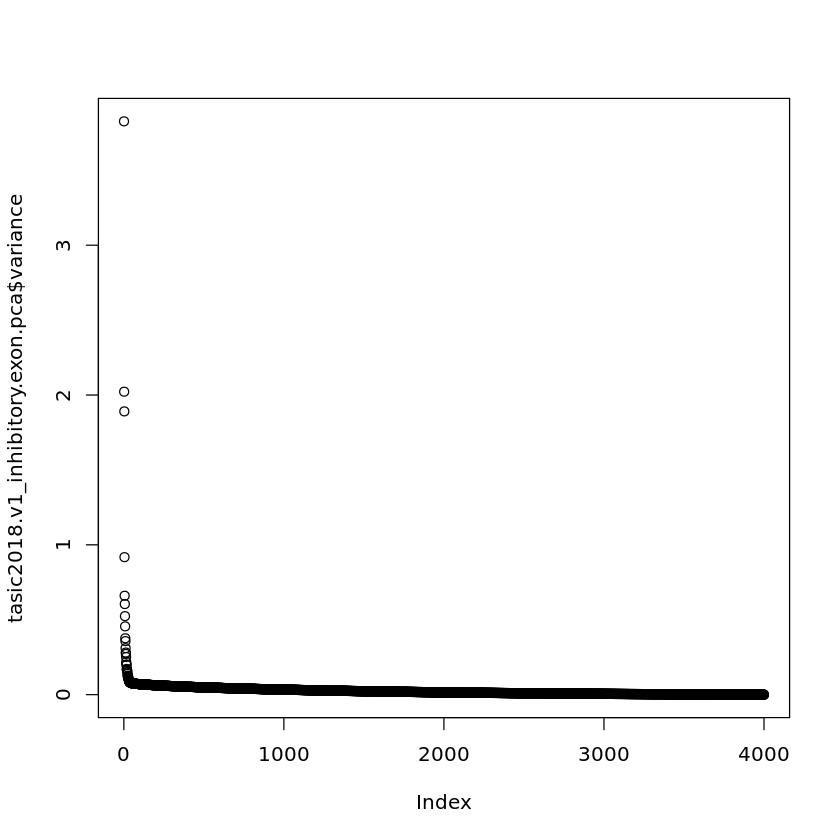

In [45]:
tasic2018.v1_inhibitory.exon.pca <- pca(tasic2018.v1_inhibitory.exon.counts.normed)
plot(tasic2018.v1_inhibitory.exon.pca$variance)

In [48]:
tPC1_fromTasic2018 <- data.frame(gene = colnames(tasic2018.v1_inhibitory.exon.counts.normed),
                                           tPC1 = tasic2018.v1_inhibitory.exon.pca$rotated$PC1) %>% arrange(tPC1)
head(tPC1_fromTasic2018)

,gene,tPC1
,<chr>,<dbl>
1,Lhx6,-54.96610
2,Sox6,-53.64161
3,Nxph1,-50.64836
4,Tmem44,-48.72819
5,Mafb,-46.94829
6,Nek7,-46.73281


In [64]:
tPC1_fromTasic2018.bugeongenesonly <- tPC1_fromTasic2018[tPC1_fromTasic2018$gene %in% bugeon2022.genes,]

print(dim(tPC1_fromTasic2018.bugeongenesonly  ))
tPC1_fromTasic2018.bugeongenesonly

[1] 56  2


,gene,tPC1
,<chr>,<dbl>
1,Lhx6,-54.9661022
8,Satb1,-44.9937914
11,Pvalb,-44.1578195
12,Crhbp,-43.8896200
42,Gabrd,-33.4854170
58,Tac1,-31.3567850
69,Calb1,-30.4076132
113,Rgs4,-26.4037109
116,Cort,-26.0674207


In [58]:
length(tPC1_fromTasic2018.bugeongenesonly$gene)
duplicated(tPC1_fromTasic2018.bugeongenesonly$gene)

[1] 56

[1] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[13] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[25] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[37] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE
[49] FALSE FALSE FALSE FALSE FALSE FALSE FALSE FALSE

In [66]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromTasic2018.bugeongenesonly$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022[tPC1.bugeon2022 %in% tPC1_fromTasic2018.bugeongenesonly$gene]){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromTasic2018.bugeongenesonly$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic <- rank.tPC1.from_rnaseq
tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromTasic2018.bugeongenesonly$gene <- as.factor(tPC1_fromTasic2018.bugeongenesonly$gene)
rownames(tPC1_fromTasic2018.bugeongenesonly)

[1] "1"    "8"    "11"   "12"   "42"   "58"   "69"   "113"  "116"  "137" 
[11] "148"  "252"  "354"  "525"  "679"  "718"  "1932" "1940" "1979" "2008"
[21] "2143" "2408" "2905" "2955" "3256" "3280" "3454" "3626" "3740" "3750"
[31] "3766" "3800" "3806" "3820" "3861" "3865" "3892" "3905" "3908" "3937"
[41] "3945" "3952" "3954" "3956" "3957" "3958" "3960" "3969" "3970" "3971"
[51] "3975" "3976" "3977" "3982" "3994" "3995"

In [67]:
head(tPC1_fromTasic2018.bugeongenesonly)

,gene,tPC1,rank_in_tasic,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
1,Lhx6,-54.96610,1,3
8,Satb1,-44.99379,2,1
11,Pvalb,-44.15782,3,10
12,Crhbp,-43.88962,4,6
42,Gabrd,-33.48542,5,21
58,Tac1,-31.35679,6,13


In [68]:
cor.test( tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic,  tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic and tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon
S = 3974, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8641832 


We can also compute it with just the Bugeon genes but it's better this way.

### Graded IEG expression along this axis.

In [71]:
iegs.tasic2018.tPC1_ranking <- tPC1_fromTasic2018[tPC1_fromTasic2018$gene %in% meta.iegs,]
iegs.tasic2018.tPC1_ranking

,gene,tPC1
,<chr>,<dbl>
265,Dusp1,-17.882861
595,Rgs2,-10.983625
643,Fbxo33,-10.364437
893,Ccdc184,-7.713809
967,Plagl1,-7.115024
1782,Tiparp,-2.170432
2492,Errfi1,1.616407
2807,Ppp1r15a,3.459686
3123,Gadd45g,5.589685


#### Tasic v1 Inihbitory Cells Activity (Sum of all metaIEGs after normalization, including ones not computed in PC)

In [80]:
# plotting IEG acitivy per cluster type
macthed.iegs <- rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered)[rownames(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered) %in% meta.iegs]
tasic2018v1_inhibitory.meta$iegsum_activity <- colSums(tasic2018.v1_inhibitory.exon.counts.normed.unfiltered[macthed.iegs ,])

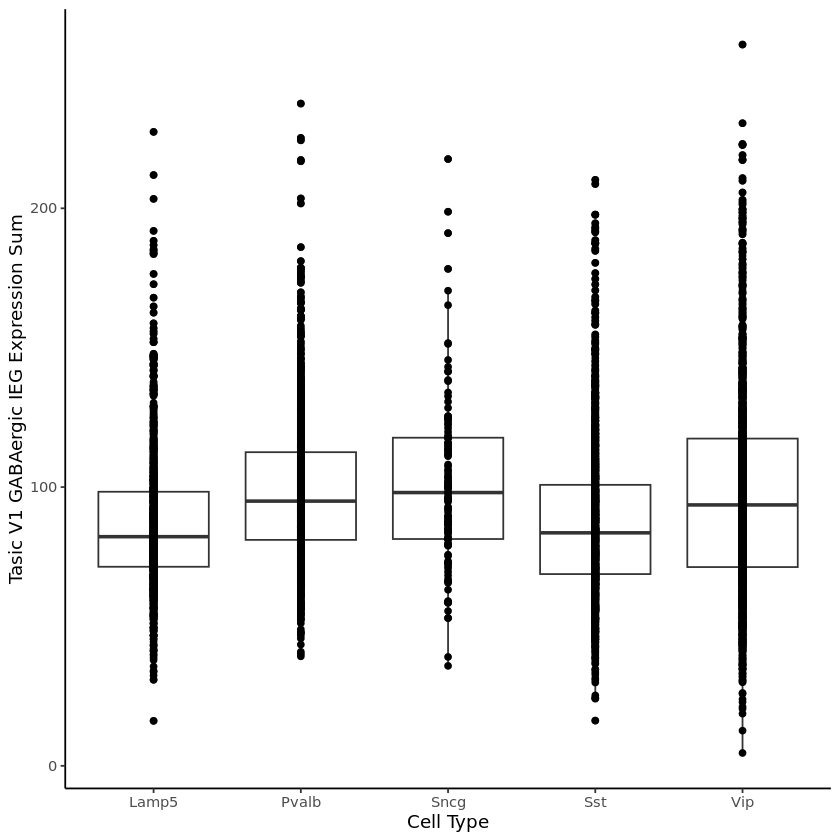

In [85]:
p <- tasic2018v1_inhibitory.meta %>% ggplot(aes(x=cell_subclass, y=iegsum_activity)) + 
  geom_boxplot() +
  geom_point()+
  xlab('Cell Type')+
  ylab('Tasic V1 GABAergic IEG Expression Sum')+
  theme_classic()
p

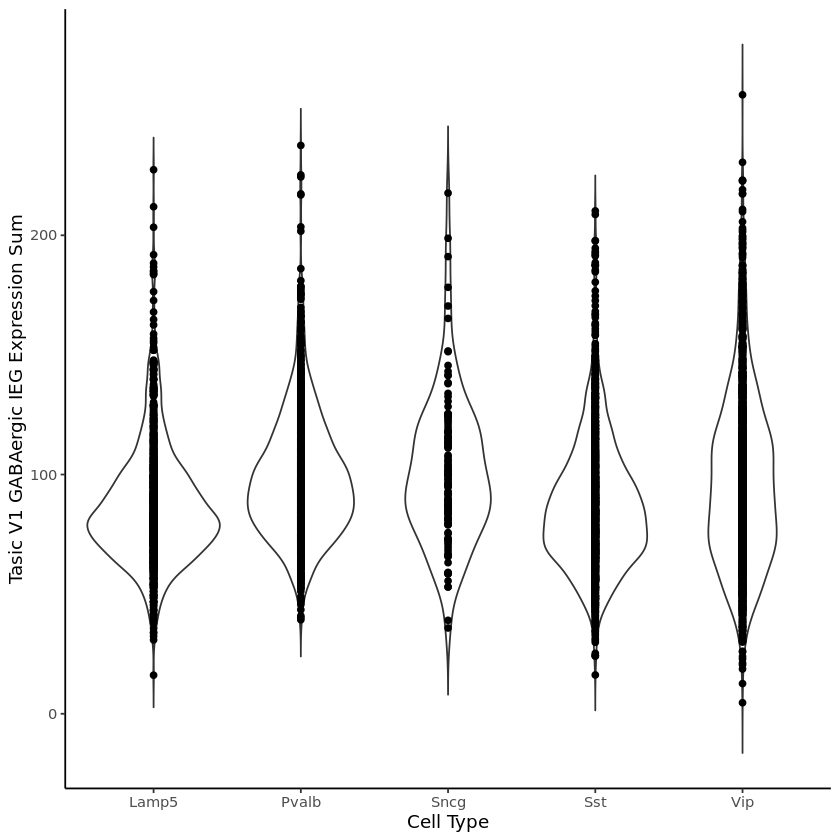

In [136]:
p <- tasic2018v1_inhibitory.meta %>% ggplot(aes(x=cell_subclass, y=iegsum_activity)) + 
  geom_violin(trim=FALSE) +
  geom_point()+
  xlab('Cell Type')+
  ylab('Tasic V1 GABAergic IEG Expression Sum')+
  theme_classic()
p


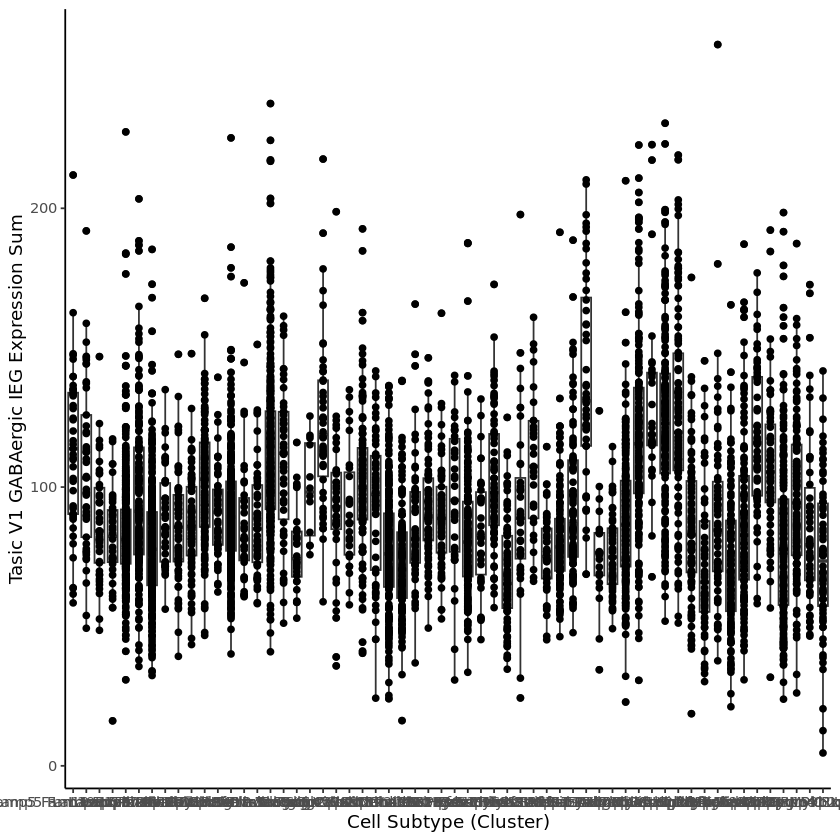

In [135]:
p <- tasic2018v1_inhibitory.meta %>% ggplot(aes(x=cell_cluster, y=iegsum_activity)) + 
  geom_boxplot() +
  geom_point()+
  xlab('Cell Subtype (Cluster)')+
  ylab('Tasic V1 GABAergic IEG Expression Sum')+
  theme_classic()
p

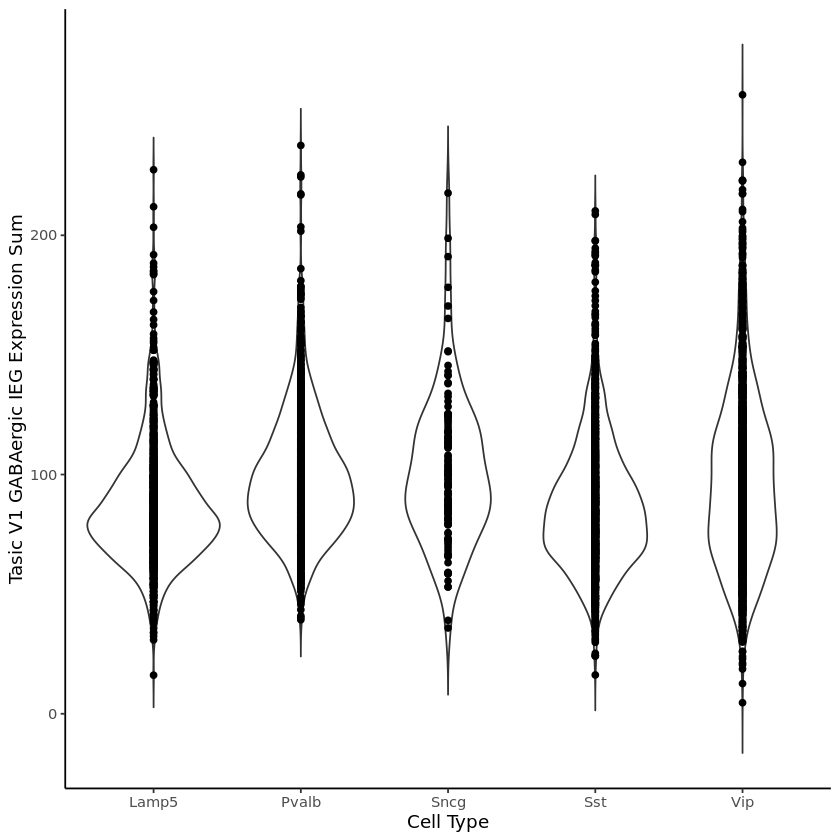

In [137]:
p <- tasic2018v1_inhibitory.meta %>% ggplot(aes(x=cell_subclass, y=iegsum_activity)) + 
  geom_violin(trim=FALSE) +
  geom_point()+
  xlab('Cell Type')+
  ylab('Tasic V1 GABAergic IEG Expression Sum')+
  theme_classic()
p

Heat map of cells activity. Cells organized by tPC1 loadings (rotation) and IEGs by PC1 scores.  Only iegs from the metaIEGl lsit in teh top 3k variable genes are included in the display, other gene were removed for computing PCA.

In [95]:
# adding this to meta to organize cells
tasic2018v1_inhibitory.meta$tPC1_score <- tasic2018.v1_inhibitory.exon.pca$loadings$PC1

In [96]:
tasic2018v1_inhibitory.meta$

[1] "F2S4_151217_005_B01" "F2S4_151217_006_B01" "F2S4_151217_006_H01"
 [4] "F2S4_151217_009_B01" "F2S4_151217_009_C01" "F2S4_151217_009_E01"
 [7] "F2S4_151217_009_F01" "F2S4_151217_009_G01" "F2S4_151217_009_H01"
[10] "F2S4_151217_010_A01"

In [167]:
tPC1cell.idx.df <- tasic2018v1_inhibitory.meta %>% 
                   select(sample_name, tPC1_score, iegsum_activity, cell_class, cell_subclass, cell_cluster)  %>% 
                   arrange(tPC1_score)

tPC1cell.idx.df$cell_class <- as.factor(tPC1cell.idx.df$cell_class)
tPC1cell.idx.df$cell_subclass <- as.factor(tPC1cell.idx.df$cell_subclass)
tPC1cell.idx.df$cell_cluster <- as.factor(tPC1cell.idx.df$cell_cluster)

In [168]:
head(tPC1cell.idx.df)

,sample_name,tPC1_score,iegsum_activity,cell_class,cell_subclass,cell_cluster
,<chr>,<dbl>,<dbl>,<fct>,<fct>,<fct>
1,F2S4_170406_007_G01,-0.02338807,95.04792,GABAergic,Pvalb,Pvalb Sema3e Kank4
2,F2S4_160401_004_B01,-0.02334360,92.89439,GABAergic,Pvalb,Pvalb Sema3e Kank4
3,F2S4_160411_001_C01,-0.02320444,124.97186,GABAergic,Pvalb,Pvalb Reln Tac1
4,F2S4_160805_005_D01,-0.02299522,118.16665,GABAergic,Pvalb,Pvalb Tpbg
5,F2S4_160401_003_A01,-0.02286787,101.88504,GABAergic,Pvalb,Pvalb Tpbg
6,F2S4_160804_003_D01,-0.02251171,114.77332,GABAergic,Pvalb,Pvalb Tpbg


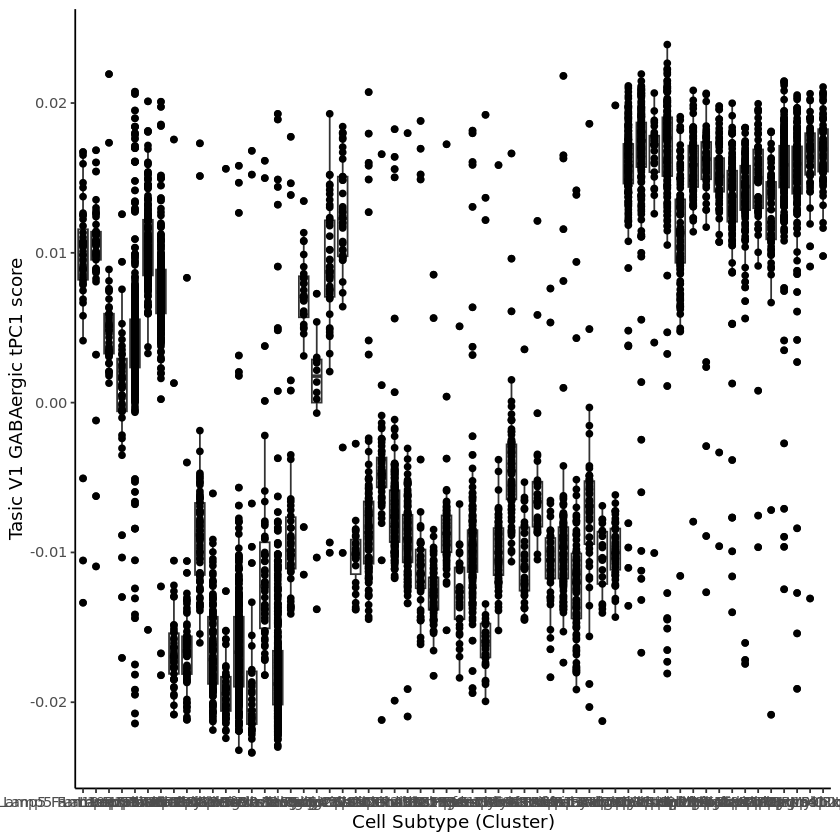

In [140]:
p <- df.tpc1.plot %>% ggplot(aes(x=cell_cluster, y=tPC1_score)) + 
  geom_boxplot() +
  geom_point()+
  xlab('Cell Subtype (Cluster)')+
  ylab('Tasic V1 GABAergic tPC1 score')+
  theme_classic()
p

In [139]:
df.tpc1.plot <- tasic2018v1_inhibitory.meta %>% 
                select(cell_cluster, tPC1_score, ) %>%
                arrange(tPC1_score)

In [102]:

iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes <- tasic2018.v1_inhibitory.exon.counts.normed[tPC1cell.idx.df$sample_name,iegs.tasic2018.tPC1_ranking$gene]
print(iegs.tasic2018.tPC1_ranking$gene[1:5])
head(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes)

[1] "Dusp1"   "Rgs2"    "Fbxo33"  "Ccdc184" "Plagl1" 


,Dusp1,Rgs2,Fbxo33,Ccdc184,Plagl1,Tiparp,Errfi1,Ppp1r15a,Gadd45g,Coq10b,Junb,Egr1,Ier2,Fos,Crem,Fosl2,Nr4a1,Pcsk1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
F2S4_170406_007_G01,0.7696837,0.9571156,0.9403221,0.9939863,-0.6371489,0.8620288,0.41218238,-0.9067642,0.3181110,0.5583448,0.58350524,-0.9092159,0.2666682,-1.11469236,-1.056472412,-0.35580538,-0.7585514,-0.8912823
F2S4_160401_004_B01,1.2633179,0.7178379,0.9711746,1.1334673,1.0106266,-0.8037414,0.37411005,0.7338840,-0.1160878,0.2934469,-0.59717233,-0.9092159,0.6174268,0.30215864,-0.363756295,-0.37116520,-0.7585514,-0.8912823
F2S4_160411_001_C01,1.2797899,0.8939437,1.0742178,0.6825209,1.3931794,0.8061979,0.49868677,0.8190237,0.8098345,0.8015170,-0.10197530,-0.9092159,0.7438198,0.78039445,0.007275711,0.93616763,-0.7585514,-0.8912823
F2S4_160805_005_D01,1.1123955,0.8632052,0.8713575,1.1387463,1.2844918,0.7447691,0.26304152,0.8620667,0.5631017,0.1926031,-0.07328672,0.6139464,-0.1833814,0.41259399,-0.918516822,0.77366034,-0.7585514,0.7083587
F2S4_160401_003_A01,1.2876876,0.8780066,0.7019608,0.9029973,-0.6371489,1.3263620,-0.06273464,0.4974113,0.5250796,-0.2802041,0.44128406,0.3208287,0.4379642,-0.06233356,-0.230615678,-0.02591347,-0.7585514,-0.8912823
F2S4_160804_003_D01,1.3218216,0.8174926,0.3723664,1.4114680,0.8177670,1.2023808,0.69609745,0.8515343,0.9539101,0.1470712,1.03721727,-0.2955898,0.6102968,0.21622725,0.522705366,-0.85039115,1.0512810,-0.8912823


In [104]:
library(pheatmap)

In [133]:
#tPC1cell.idx.df

#        annotation_row = my_sample_row)
#annot <- tPC1cell.idx.df %>% select(cell_subclass, cell_cluster)
annot <- tPC1cell.idx.df %>% select(cell_class, cell_subclass)
#annot <- as.data.frame(annot))
rownames(annot) <- tPC1cell.idx.df$sample_name

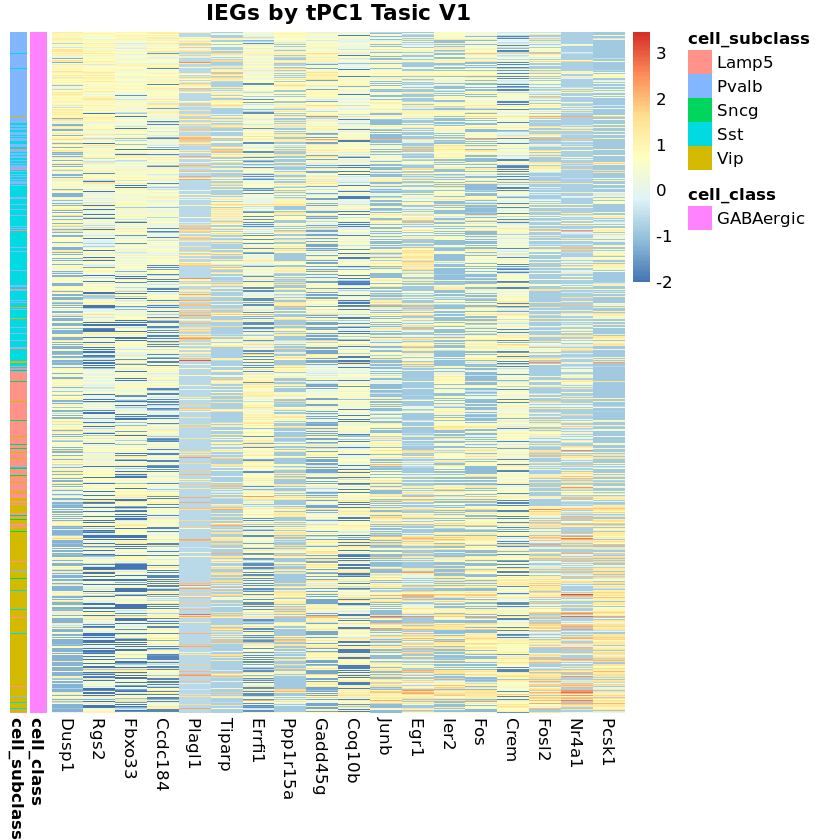

In [134]:
temp_hm <-pheatmap(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes,
                   cluster_rows = FALSE, cluster_cols = FALSE, show_rownames = F,
                   main = "IEGs by tPC1 Tasic V1",
                   annotation_row = annot)

In [115]:
# doing it with cell cluster means
tPC1cell.idx.df

In [174]:
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$Subtype <- tPC1cell.idx.df$cell_cluster
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$tPC1_score <- tPC1cell.idx.df$tPC1_score
iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$iegsum_activity <- tPC1cell.idx.df$iegsum_activity

In [175]:
colnames(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes)

[1] "Dusp1"           "Rgs2"            "Fbxo33"          "Ccdc184"        
 [5] "Plagl1"          "Tiparp"          "Errfi1"          "Ppp1r15a"       
 [9] "Gadd45g"         "Coq10b"          "Junb"            "Egr1"           
[13] "Ier2"            "Fos"             "Crem"            "Fosl2"          
[17] "Nr4a1"           "Pcsk1"           "Subtype"         "tPC1_score"     
[21] "iegsum_activity"

In [176]:
iegsbytpc1.subtype_means.df <- iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes %>%
                               select(-Subtype) %>%
                               aggregate(list(iegsbytpc1.tasicv1gabaergic.normed.sclaed.top3kgenes$Subtype), mean) %>%
                               arrange(tPC1_score) %>%
                               column_to_rownames(var ='Group.1')

In [177]:
head(iegsbytpc1.subtype_means.df)

,Dusp1,Rgs2,Fbxo33,Ccdc184,Plagl1,Tiparp,Errfi1,Ppp1r15a,Gadd45g,Coq10b,Junb,Egr1,Ier2,Fos,Crem,Fosl2,Nr4a1,Pcsk1,tPC1_score,iegsum_activity
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Pvalb Reln Itm2a,0.7805565,0.8161857,0.3435337,0.9917719,1.1317763,-0.08171025,0.01852479,0.11689678,0.18990671,-0.139709799,-0.10326998,-0.6275897,0.06127679,0.02804553,-1.10215991,-0.22984556,-0.5273000,-0.7640620,-0.01859927,91.10385
Pvalb Tpbg,0.7671531,0.7878046,0.5092302,0.5088286,0.2562754,0.72663611,0.25919945,0.26514268,0.67553334,0.276767929,0.27617671,0.3576513,0.24596454,0.54152678,-0.02986119,0.31832789,-0.3033207,-0.5327801,-0.01731527,111.44125
Pvalb Sema3e Kank4,0.4662238,0.6810023,0.5315553,0.6497598,-0.1138940,0.01133456,0.09187778,0.03641029,0.04613777,0.008625778,-0.52237595,-0.7620702,0.06484630,-0.56126296,-0.82690723,-0.40429013,-0.7291706,-0.8209835,-0.01716049,87.93852
Pvalb Gpr149 Islr,0.8671825,0.4689668,0.3256466,0.9354278,0.2143614,0.15171633,-0.07688256,0.23186647,0.44087480,0.027732927,0.05534812,-0.1452513,0.20477556,0.41671239,-0.16691163,-0.09436766,-0.2926746,-0.6428266,-0.01646599,101.66935
Pvalb Calb1 Sst,0.3393994,0.3738435,0.1981442,0.1010664,-0.1393432,-0.26766917,0.22354997,0.08234852,0.42481615,0.046513049,-0.25736149,-0.6397812,-0.04887502,-0.37387789,-0.16250957,-0.23674842,-0.5308195,-0.7123156,-0.01612382,85.77001
Pvalb Reln Tac1,0.7024928,0.6748992,0.2008147,0.4979065,0.5059622,-0.11283960,0.02720282,0.05464076,0.44761632,-0.220773037,-0.06231304,-0.5046651,0.12086854,-0.21711412,-0.46735951,-0.14268449,-0.4951048,-0.7208033,-0.01597730,91.47010


In [178]:
tPC1_mean.df <- data.frame( tPC1_meanscore = iegsbytpc1.subtype_means.df$tPC1_score,
                            iegsum_meanactivity = iegsbytpc1.subtype_means.df$iegsum_activity)
rownames(tPC1_mean.df) <- rownames(iegsbytpc1.subtype_means.df)
tPC1_mean.df$relative.scaled.means <- scale(tPC1_mean.df$tPC1_meanscore)
tPC1_mean.df$relative.scaled.iegsum_meanactivity  <- scale(tPC1_mean.df$iegsum_meanactivity)

In [186]:
subtype_to_type_annotation <- function(subtype_string, list_of_subtypes, list_of_types){
                                #checks the strings of subtypes to for begingin string
                                #to map to a type, ends loop if one is detected returns 
                                # what it was given, returns match if it finds something 
                                # and en empty string if there is no match
                                # includes a break stement to stop loop once match is found
                                # assumes list_of_subtypes and list_of_types are same length
                                # with corresponging entries
                                output.string <- ""
                                for(i in c(1:length(list_of_subtypes))){
                                if(startsWith(subtype_string, list_of_subtypes[i])){
                                   output.string <- list_of_types[i]
                                   break
                                    }# end of ifstatement
                                  }# end of for loop
                                return(output.string)
                                }# end of function

In [191]:
subclass.names <- unique(tasic2018v1_inhibitory.meta$cell_subclass)
subclass.names

[1] "Pvalb" "Vip"   "Lamp5" "Sst"   "Sncg"

In [202]:
tPC1_mean.df$subclass <- sapply(rownames(tPC1_mean.df), FUN = function(x) subtype_to_type_annotation(x, types.names, types.names) )

In [179]:
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -tPC1_score)
iegsbytpc1.subtype_means.df <- select(iegsbytpc1.subtype_means.df, -iegsum_activity)

In [203]:
head(tPC1_mean.df)

,tPC1_meanscore,iegsum_meanactivity,relative.scaled.means,relative.scaled.iegsum_meanactivity,subclass
,<dbl>,<dbl>,"<dbl[,1]>","<dbl[,1]>",<chr>
Pvalb Reln Itm2a,-0.01859927,91.10385,-1.515483,-0.1567791,Pvalb
Pvalb Tpbg,-0.01731527,111.44125,-1.408025,1.1391305,Pvalb
Pvalb Sema3e Kank4,-0.01716049,87.93852,-1.395072,-0.3584754,Pvalb
Pvalb Gpr149 Islr,-0.01646599,101.66935,-1.336950,0.5164600,Pvalb
Pvalb Calb1 Sst,-0.01612382,85.77001,-1.308313,-0.4966536,Pvalb
Pvalb Reln Tac1,-0.01597730,91.47010,-1.296052,-0.1334410,Pvalb


In [204]:
subclass.df <- data.frame('Subclass'=as.factor(tPC1_mean.df$subclass))
rownames(subclass.df) <- rownames(iegsbytpc1.subtype_means.df)

In [229]:
library(dichromat)

In [217]:
mycolors <- c('#4daf4a','#377eb8','#e41a1c','#984ea3','#ff7f00')
names(mycolors) <- unique(subclass.df$Subclass)
mycolors <- list(mycolors = mycolors)
mycolors

$mycolors
    Pvalb       Sst      Sncg     Lamp5       Vip 
"#4daf4a" "#377eb8" "#e41a1c" "#984ea3" "#ff7f00"

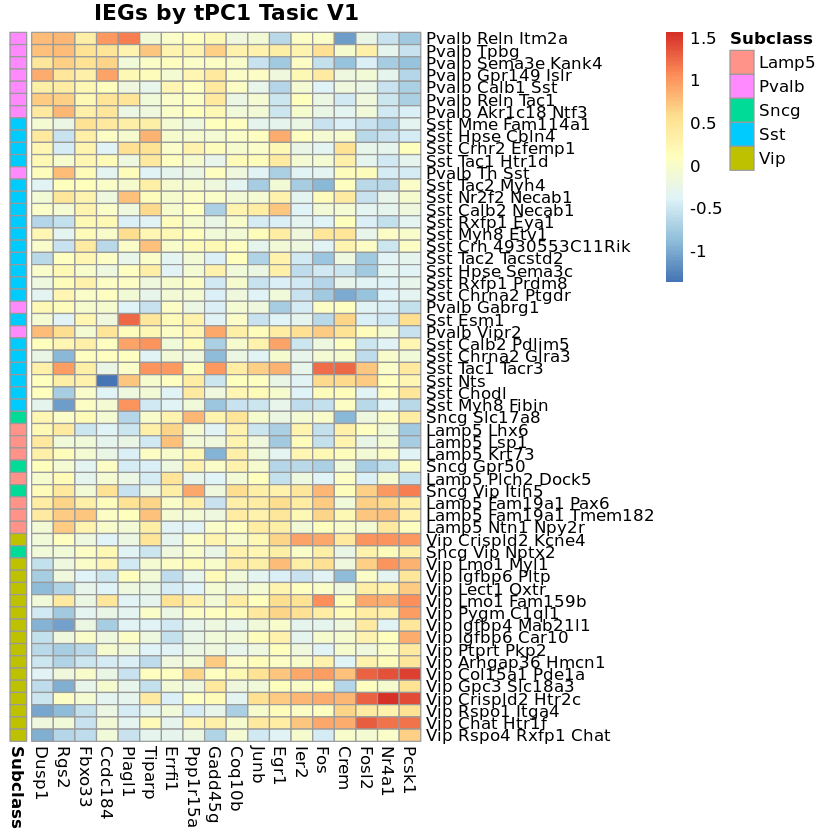

In [238]:
#annotation_colors = mycolors,

temp_hm <-pheatmap(iegsbytpc1.subtype_means.df,
                   cluster_rows = FALSE, cluster_cols = FALSE,
                   annotation_row = subclass.df,
                   main = "IEGs by tPC1 Tasic V1")

In [239]:
save_pheatmap(temp_hm, filename='Tasci_tPC1_V1_GABAergic_meanIEGexpression.png', width = 600, height=600)

png 
  2

In [115]:
### Tasic again with just the bugeon genes

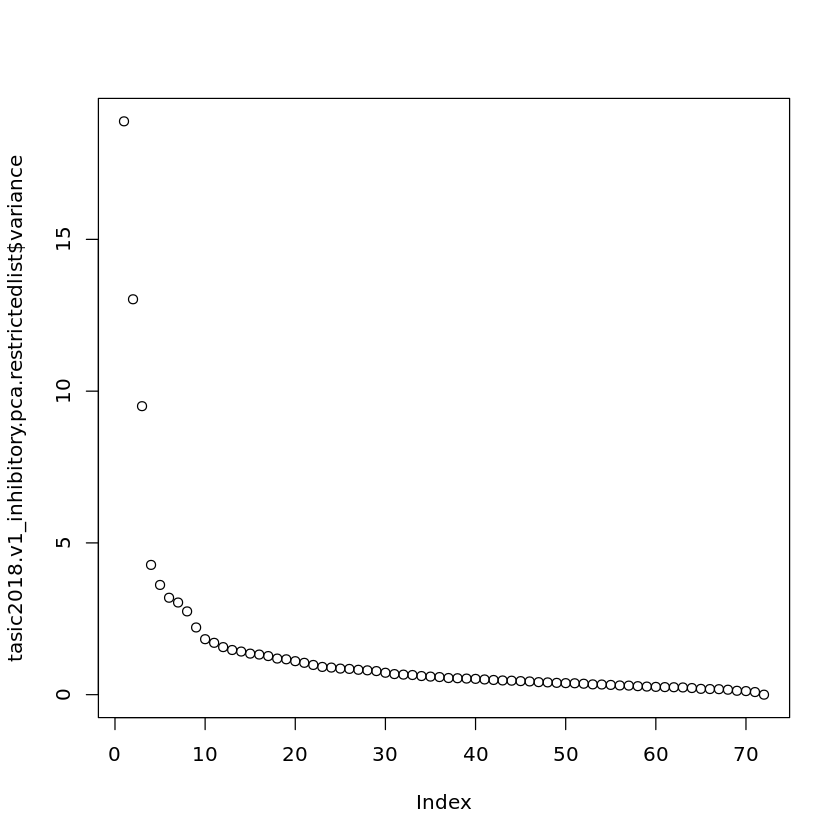

In [233]:
# can be pulled from the OG coutns datasets we just need to re run the scaling or whatever
tasic2018.v1_inhibitory.pca.restrictedlist <- pca(tasic2018.v1_inhibitory.exon.counts.normed[,bugeon2022.genes])
plot(tasic2018.v1_inhibitory.pca.restrictedlist$variance)

In [275]:
tPC1_fromTasic2018.bugeongenesonly <- data.frame(gene = bugeon2022.genes,
                                           tPC1 = tasic2018.v1_inhibitory.pca.restrictedlist$rotated$PC1) %>% arrange(tPC1)
    
print(dim(tPC1_fromTasic2018.bugeongenesonly  ))
tPC1_fromTasic2018.bugeongenesonly

[1] 72  2


gene,tPC1
<chr>,<dbl>
Vip,-55.93321
Rgs10,-53.23526
Cxcl14,-50.88541
Htr3a,-47.06076
Cnr1,-46.30159
Kit,-44.74955
Crh,-43.85972
Sema3c,-42.67792
Tac2,-42.16533


In [272]:
# I would like to point out Rgs4 is also an IEG, shows up as important in active dentate gyrus cells as well

In [276]:
# careful here PCA can flip signs, just make sure Pvalb and Vip are at opposing ends of the rankings
rank.tPC1.from_rnaseq <- c(1:length(tPC1_fromTasic2018.bugeongenesonly$gene))
rank.tPC1.from_coppaFISH <- c()
for(thisgene in tPC1.bugeon2022){
    position_in_rnaseqPC1 <- match(thisgene, tPC1_fromTasic2018.bugeongenesonly$gene)
    rank.tPC1.from_coppaFISH <- c(rank.tPC1.from_coppaFISH, position_in_rnaseqPC1 ) # append position in other list
}

tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic <- rank.tPC1.from_rnaseq
tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon <- rank.tPC1.from_coppaFISH
tPC1_fromTasic2018.bugeongenesonly$gene <- as.factor(tPC1_fromTasic2018.bugeongenesonly$gene)
rownames(tPC1_fromrnaseq.bugeongenes)

[1] "34"    "48"    "275"   "543"   "559"   "651"   "1204"  "1275"  "1328" 
[10] "1479"  "1504"  "1544"  "1573"  "1693"  "1931"  "1947"  "1954"  "2797" 
[19] "3063"  "3450"  "3487"  "3614"  "3646"  "3818"  "3843"  "3849"  "4143" 
[28] "4182"  "4201"  "4309"  "4424"  "4600"  "4644"  "4964"  "4991"  "5067" 
[37] "5096"  "5209"  "5493"  "5618"  "5755"  "6250"  "6303"  "6491"  "7140" 
[46] "7277"  "7360"  "7409"  "8074"  "8137"  "8172"  "8746"  "8793"  "8865" 
[55] "9035"  "9097"  "9155"  "9548"  "10250" "10320" "10335" "10385" "10560"
[64] "10671" "10795" "11144" "11209" "11380" "11518" "12184" "12308" "12597"

In [277]:
head(tPC1_fromTasic2018.bugeongenesonly)

,gene,tPC1,rank_in_tasic,rank_in_bugeon
,<fct>,<dbl>,<int>,<int>
1,Vip,-55.93321,1,69
2,Rgs10,-53.23526,2,53
3,Cxcl14,-50.88541,3,26
4,Htr3a,-47.06076,4,72
5,Cnr1,-46.30159,5,62
6,Kit,-44.74955,6,66


In [281]:
cor.test( tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic,  tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon, 
         method = 'spearman', data = tPC1_fromrnaseq.bugeongenes)


	Spearman's rank correlation rho

data:  tPC1_fromTasic2018.bugeongenesonly$rank_in_tasic and tPC1_fromTasic2018.bugeongenesonly$rank_in_bugeon
S = 107424, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.8012072 


In [ ]:
# plot cells average acitivity score across the clusters, show some are more active
# plot the individual cells IEG expression vs their rank along the gradient
#, rank the IEGs by their position on tPC1, consider restricting to protien coding genes
# plot the clusters averag IEG expression again IEGs ordered by their position on PC1 and clusters ordered by their cells average
# position on PC1 posibly just using the bugeon genes